## **Importing Modules**

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
# from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
# from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError as net_mse


/home/xviix/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-11-01 04:56:52.071800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 04:56:52.071839: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## **Exploratory Data Analysis (EDA)**

### **Reading in Datasets**

In [2]:
train = pd.read_csv("./Data/Train.csv", sep=",")

In [3]:
train.head()


,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
0,VHL12546,Abuja,Honda,Accord Coupe EX V-6,"2,011",Silver,2.2,Nigerian Used,NaN
1,VHL18827,Ibadan,Hyundai,Sonata,"2,012",Silver,3.5,Nigerian Used,"125,000"
2,VHL19499,Lagos,Lexus,RX 350,"2,010",Red,9.2,Foreign Used,"110,852"
3,VHL17991,Abuja,Mercedes-Benz,GLE-Class,"2,017",Blue,22.8,Foreign Used,"30,000"
4,VHL12170,Ibadan,Toyota,Highlander,"2,002",Red,2.6,Nigerian Used,"125,206"


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7205 entries, 0 to 7204
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VehicleID               7205 non-null   object 
 1   Location                7205 non-null   object 
 2   Maker                   7205 non-null   object 
 3   Model                   7205 non-null   object 
 4   Year                    7184 non-null   object 
 5   Colour                  7205 non-null   object 
 6   Amount (Million Naira)  7188 non-null   float64
 7   Type                    7008 non-null   object 
 8   Distance                4845 non-null   object 
dtypes: float64(1), object(8)
memory usage: 506.7+ KB


In [5]:
train.isnull().sum()


VehicleID                    0
Location                     0
Maker                        0
Model                        0
Year                        21
Colour                       0
Amount (Million Naira)      17
Type                       197
Distance                  2360
dtype: int64

In [6]:
test = pd.read_csv("./Data/Test.csv", sep=",")

In [7]:
test.head()


,VehicleID,Location,Maker,Model,Year,Colour,Type,Distance
0,VHL18518,Abuja,BMW,323i,"2,008",White,Foreign Used,30524.0
1,VHL17149,Lagos,Toyota,Camry,"2,013",White,Foreign Used,NaN
2,VHL10927,Lagos,Toyota,Highlander Limited V6,"2,005",Gold,Foreign Used,NaN
3,VHL12909,Lagos,Toyota,Camry,"2,011",Gray,Foreign Used,166839.0
4,VHL12348,Lagos,Lexus,ES 350 FWD,"2,013",Red,Foreign Used,88862.0


In [8]:
train["data"] = "train"
test["data"] = "test"



In [9]:
test.isnull().sum()


VehicleID      0
Location       0
Maker          0
Model          0
Year           2
Colour         0
Type          54
Distance     676
data           0
dtype: int64

### **Function Definitions**

In [10]:
def outlier_detection(X, n, cols=None):
    """
        A function to detect outliers using tuckey fences
    """
    outlier_idx = []

    if cols is not None:
        for col in cols:
            Q1 = np.nanpercentile(X[col], 25)
            Q3 = np.nanpercentile(X[col], 75)

            IQR = Q3 - Q1

            upper = (IQR * 1.5) + Q3
            lower = Q1 - (IQR * 1.5)

            outliers = X[(X[col] < lower) | (X[col] > upper)].index

            outlier_idx.extend(outliers)

            print(f"{col} has lower limit of {lower} and upper limit of {upper}")

        outlier_idx = Counter(outlier_idx)
        multiple_outliers = list(k for k, v in outlier_idx.items() if v >= n)

    else:
        for col in X.columns:
            Q1 = np.nanpercentile(X[col], 25)
            Q3 = np.nanpercentile(X[col], 75)

            IQR = Q3 - Q1

            upper = (IQR * 1.5) + Q3
            lower = Q1 - (IQR * 1.5)

            outliers = X[(X[col] < lower) | (X[col] > upper)].index

            outlier_idx.extend(outliers)

            print(f"{col} has lower limit of {lower} and upper limit of {upper}")

        outlier_idx = Counter(outlier_idx)
        multiple_outliers = list(k for k, v in outlier_idx.items() if v >= n)

    return multiple_outliers


def yearTransform(X, col_name="Year"):
    """Function to transform the Year column into a datetime feature
       X - DataFrame from which the year column is to be changed
       col_name - Name of the year column to be changed
    """

    df = X.copy()

    df[col_name] = df[col_name].apply(
        lambda x: str(x).replace(",", "")).astype(np.float64)

    year_median = df[col_name].median()
    df[col_name].fillna(year_median, inplace=True)

    df[col_name] = pd.to_datetime(df[col_name], format="%Y")
    df[col_name] = pd.DatetimeIndex(df[col_name]).year

    print(f"maker_location - {df.shape}")

    return df


def distanceTransform(X, col_name="Distance"):
    """
    Function to transform the Distance column into a float

    X - DataFrame from which the year column is to be changed
    col_name - Name of the year column to be changed
    """

    df = X.copy()

    df[col_name] = df[col_name].apply(
        lambda x: str(x).replace(",", "")).astype(np.float64)

    print(f"distanceTransform - {df.shape}")

    return df


def distanceImpute(X):

    df = X.copy()

    distance_group = df.groupby("Type")["Distance"].median()

    # type_list = ["Brand New", "Foreign Used", "Nigerian Used"]

    brand_new_train = df[df["Type"] == "Brand New"]
    brand_new_train["Distance"].fillna(distance_group[0], inplace=True)

    foreign_train = df[df["Type"] == "Foreign Used"]
    foreign_train["Distance"].fillna(distance_group[1], inplace=True)

    naija_train = df[df["Type"] == "Nigerian Used"]
    naija_train["Distance"].fillna(distance_group[2], inplace=True)

    # other_train = df[df["Type"] not in type_list]
    # other_train["Distance"]

    print(f"distanceImputeA - {df.shape}")

    df = pd.concat([brand_new_train, foreign_train,  naija_train])

    print(f"distanceImpute - {df.shape}")

    return df


def typeImpute(X):

    df = X.copy()

    df["Type"].fillna(method="ffill", inplace=True)

    print(f"typeImpute - {df.shape}")

    return df


def maker_location(X):

    df = X.copy()

    maker_location = []
    japan = ["Toyota", "Lexus", "Honda",
             "Acura", "Nissan", "Mazda",
             "Mitsubishi", "Infiniti", "Scion",
             "Suzuki", "Subaru"]

    germany = ["Mercedes-Benz", "BMW", "Volkswagen",
               "Audi", "Porsche", "Opel",
               "Brabus"]

    korea = ["Hyundai", "Kia"]

    uk = ["Rolls-Royce", "Jaguar", "mini",
          "Bentley", "Land Rover", "MG", "Rover"]

    italy = ["Maserati", "Lamborghini", "Ferrari"]

    usa = ["Cadillac", "Ford", "Pontiac", "Dodge",
           "Jeep", "Chevrolet", "Saturn", "GMC", "Lincoln",
           "Buick", "Chrysler", "Hummer", "King"]

    france = ["Peugeot", "Renault", "Citroen"]

    sweden = ["Volvo", "Saab"]

    others = ["GAC", "JAC", "BAW", "IVM", "Skoda"]

    for car in df["Maker"]:
        if car in japan:
            maker_location.append("Japan")
        elif car in germany:
            maker_location.append("Germany")
        elif car in korea:
            maker_location.append("Korea")
        elif car in uk:
            maker_location.append("UK")
        elif car in italy:
            maker_location.append("Italy")
        elif car in usa:
            maker_location.append("USA")
        elif car in france:
            maker_location.append("France")
        elif car in sweden:
            maker_location.append("Sweden")
        else:
            maker_location.append("Others")

    df["maker_location"] = maker_location

    print(f"maker_location - {df.shape}")
    return df


def model_extract(X):

    df = X.copy()

    model_list = []

    for model in df["Model"]:
        model_list.append(model.split()[0])

    df["Model_name"] = model_list

    print(f"model_extract - {df.shape}")

    return df


def model_year(X):

    df = X.copy()
    df["Model_year"] = df["Model"] + " " + \
        str(df["Year"]).split("\n")[0].split()[1]

    # train["Model_year"]
    # sum = 0
    for car in df["Model_year"]:
        car = car.split()[0] + " " + car.split()[-1]

        if "2020 2020" in car:
            car.replace("2020 2020", '2020')

        # sum += 1
        # print(car)
    # print(sum)
    print(f"model_year - {df.shape}")

    return df


def amountImpute(X):

    df = X.copy()

    amount_median = df["Amount (Million Naira)"].median()
    df["Amount (Million Naira)"] = df["Amount (Million Naira)"].fillna(
        amount_median)

    return df


In [11]:
def process(X):
    
    df = X.copy()
    
    df = yearTransform(df)
    df = typeImpute(df)
    df = distanceTransform(df)
    df = distanceImpute(df)
    df = maker_location(df)
    df = model_extract(df)
    df = model_year(df)

    if "Amount (Million Naira)" in df.columns:
        df = amountImpute(df)

    return df


In [12]:
class Processing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy()

        if df is not None:
            df = process(df)
            return df
        else:
            pass


class MultiEncoder:
    def __init__(self, columns=None, d_columns=None):
        self.columns = columns
        self.dummys = d_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None,):
        df = X.copy()

        if self.dummys is not None:
            dummies = pd.get_dummies(df[self.dummys])
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(self.dummys, axis=1)

        if self.columns is not None:
            for col in self.columns:
                df[col] = LabelEncoder().fit_transform(df[col])

        else:
            for colname, col in df.iteritems():
                df[colname] = LabelEncoder().fit_transform(col)

        return df

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


**Processing Data** <br>
Processing data according to the functions defined above

In [13]:
train = Processing().fit_transform(train)
test = Processing().fit_transform(test)

maker_location - (7205, 10)
typeImpute - (7205, 10)
distanceTransform - (7205, 10)


/tmp/ipykernel_259248/291918517.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_new_train["Distance"].fillna(distance_group[0], inplace=True)
/tmp/ipykernel_259248/291918517.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreign_train["Distance"].fillna(distance_group[1], inplace=True)
/tmp/ipykernel_259248/291918517.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naija_train["Distance"].fillna(distance_group[2]

distanceImputeA - (7205, 10)
distanceImpute - (7205, 10)
maker_location - (7205, 11)
model_extract - (7205, 12)
model_year - (7205, 13)
maker_location - (2061, 9)
typeImpute - (2061, 9)
distanceTransform - (2061, 9)


/tmp/ipykernel_259248/291918517.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_new_train["Distance"].fillna(distance_group[0], inplace=True)
/tmp/ipykernel_259248/291918517.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foreign_train["Distance"].fillna(distance_group[1], inplace=True)
/tmp/ipykernel_259248/291918517.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naija_train["Distance"].fillna(distance_group[2]

distanceImputeA - (2061, 9)
distanceImpute - (2061, 9)
maker_location - (2061, 10)
model_extract - (2061, 11)
model_year - (2061, 12)


In [14]:
train.isnull().sum(), test.isnull().sum()

data = pd.concat([train, test], ignore_index=True)

data.isnull().sum()

VehicleID                    0
Location                     0
Maker                        0
Model                        0
Year                         0
Colour                       0
Amount (Million Naira)    2061
Type                         0
Distance                     0
data                         0
maker_location               0
Model_name                   0
Model_year                   0
dtype: int64

### **Visualizations**

#### **Distance Distribution**

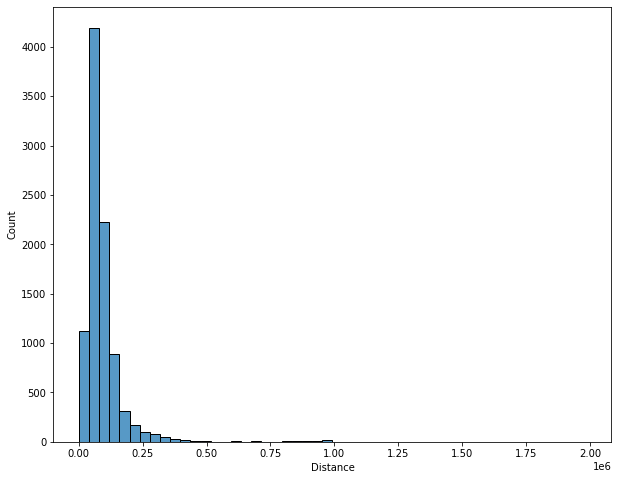

In [15]:
plt.figure(figsize=(10, 8))
sns.histplot(data=data,
            x="Distance", bins=50)

plt.savefig("./Image/distance_distribution.jpg")

#### **Distance density across different locations**

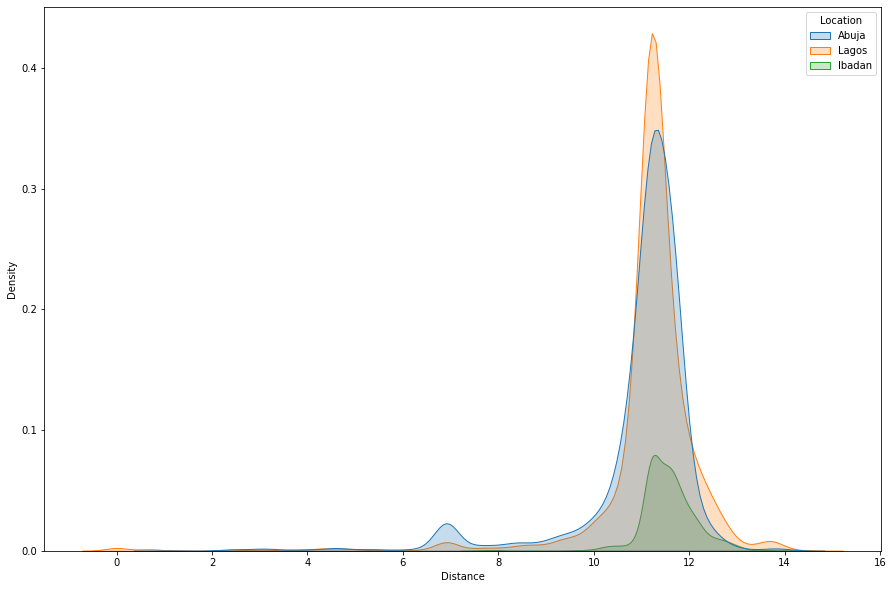

In [16]:
plt.figure(figsize=(15, 10))
sns.kdeplot(np.log(data["Distance"]),
            color="orange", shade=True,
            hue=data["Location"])

plt.savefig("./Image/location_distance_density.jpg")

#### **Distance on cars classified by their types**

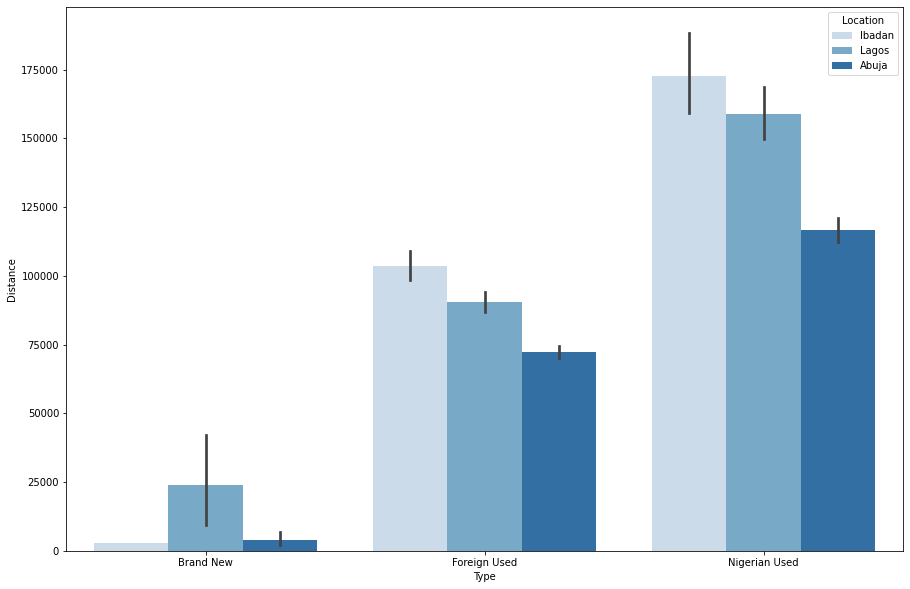

In [17]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Type", y="Distance",
            data=data, hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")

plt.savefig("./Image/car_distance_by_type.jpg")

<AxesSubplot:xlabel='Type', ylabel='Distance'>

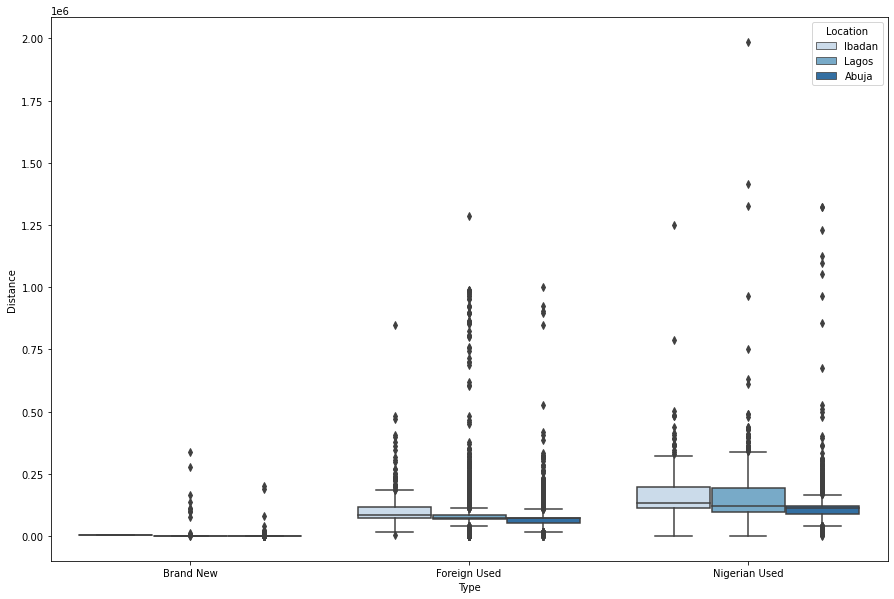

In [18]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Type", y="Distance",
            data=data, hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")


#### **Price of each car type in each location**

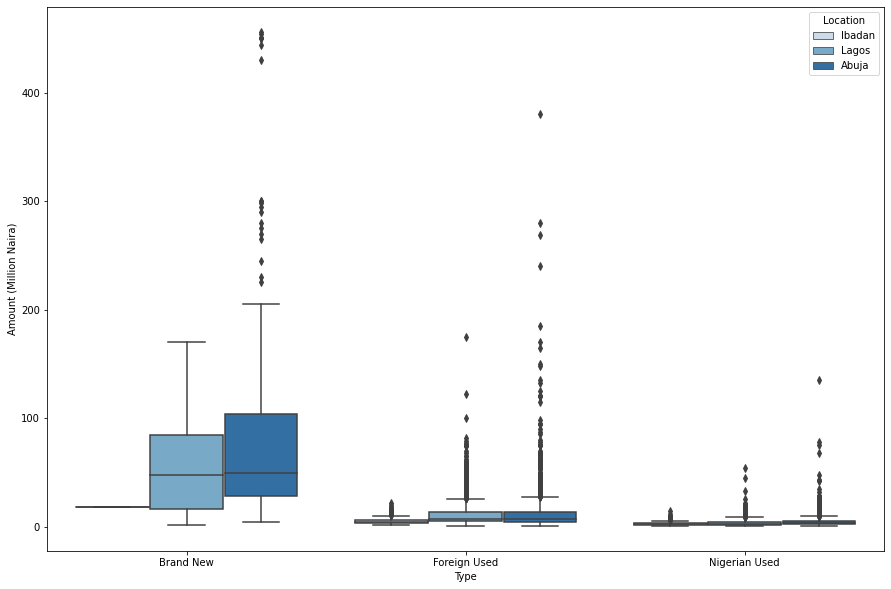

In [19]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Type", y="Amount (Million Naira)",
            data=data, hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")

plt.savefig("./Image/car_price_location.jpg")

In [20]:
naija_used = data[data["Type"] == "Nigerian Used"]
nu_75 = np.nanpercentile(naija_used["Amount (Million Naira)"], 75)

In [21]:
data[data["Amount (Million Naira)"] > nu_75]

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance,data,maker_location,Model_name,Model_year
0,VHL16048,Abuja,Toyota,Hilux,2020,White,23.00,Brand New,7523.0,train,Japan,Hilux,Hilux 2020
1,VHL14714,Abuja,Toyota,Hilux,2021,White,23.00,Brand New,100.0,train,Japan,Hilux,Hilux 2020
2,VHL11970,Lagos,Lexus,LX,2018,Black,52.00,Brand New,1000.0,train,Japan,LX,LX 2020
3,VHL10039,Abuja,Mercedes-Benz,G-Class G 63 AMG,2021,White,195.00,Brand New,1000.0,train,Germany,G-Class,G-Class G 63 AMG 2020
4,VHL13623,Abuja,Toyota,RAV4 Limited FWD,2020,Green,27.00,Brand New,854.0,train,Japan,RAV4,RAV4 Limited FWD 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7186,VHL10334,Lagos,Lexus,RX 350 AWD,2008,Black,5.06,Nigerian Used,142273.0,train,Japan,RX,RX 350 AWD 2020
7189,VHL15406,Abuja,Toyota,Land Cruiser 4 V6 GX-R,2015,Black,18.00,Nigerian Used,37088.0,train,Japan,Land,Land Cruiser 4 V6 GX-R 2020
7190,VHL16827,Abuja,Lexus,RX,2010,Gray,6.40,Nigerian Used,65000.0,train,Japan,RX,RX 2020
7192,VHL10130,Abuja,Ford,Explorer,2016,Brown,7.50,Nigerian Used,93852.0,train,USA,Explorer,Explorer 2020


#### **Plot of Cars that have their prices above the 75th percentile of the dataset**

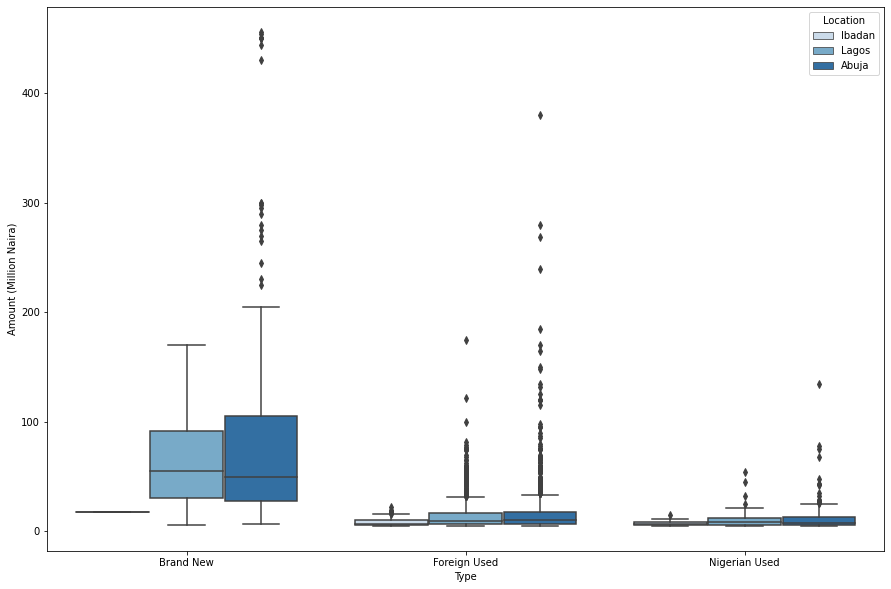

In [22]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Type", y="Amount (Million Naira)",
            data=data[data["Amount (Million Naira)"] > nu_75], 
            hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")

plt.savefig("./Image/cars_with_prices_above_75th.jpg")

#### **Plot of Cars that have their prices above the 75th percentile of the dataset (Brand New Cars)**

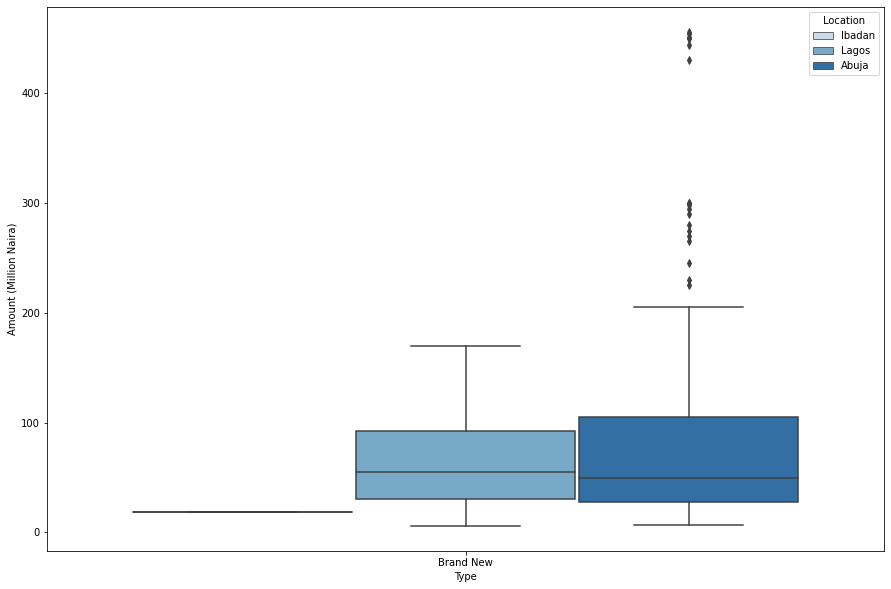

In [23]:

plt.figure(figsize=(15, 10))

sns.boxplot(x="Type", y="Amount (Million Naira)",
            data=data[(data["Amount (Million Naira)"] > nu_75)
                      & (data["Type"] == "Brand New")],
            hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")

plt.savefig("./Image/new_cars_with_prices_above_75th.jpg")

#### **Plot of Cars that have their prices above the 75th percentile of the dataset (Nigerian Used Cars)**

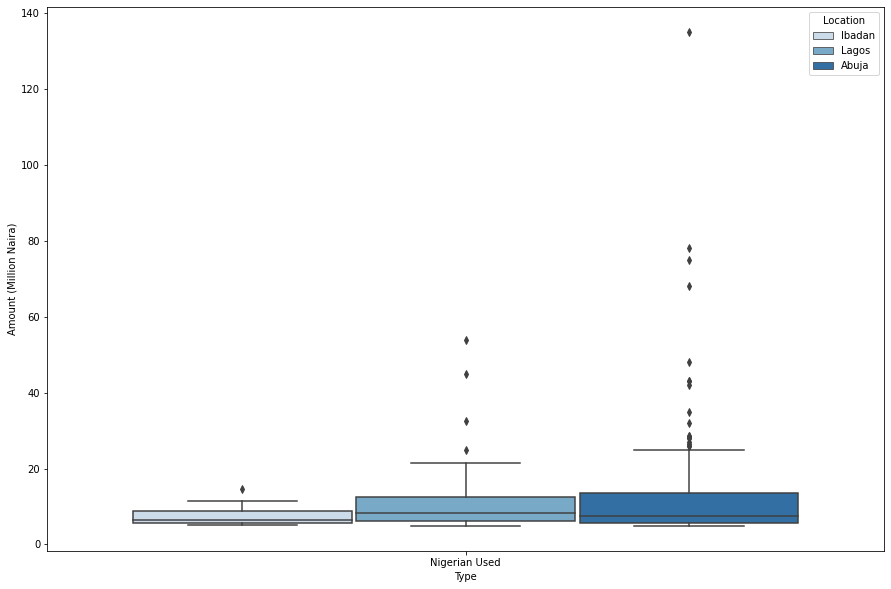

In [24]:

plt.figure(figsize=(15, 10))

sns.boxplot(x="Type", y="Amount (Million Naira)",
            data=data[(data["Amount (Million Naira)"] > nu_75)
                      & (data["Type"] == "Nigerian Used")],
            hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")

plt.savefig("./Image/nu_cars_with_prices_above_75th.jpg")

#### **Plot of Cars that have their prices above the 75th percentile of the dataset (Foreign Used Cars)**

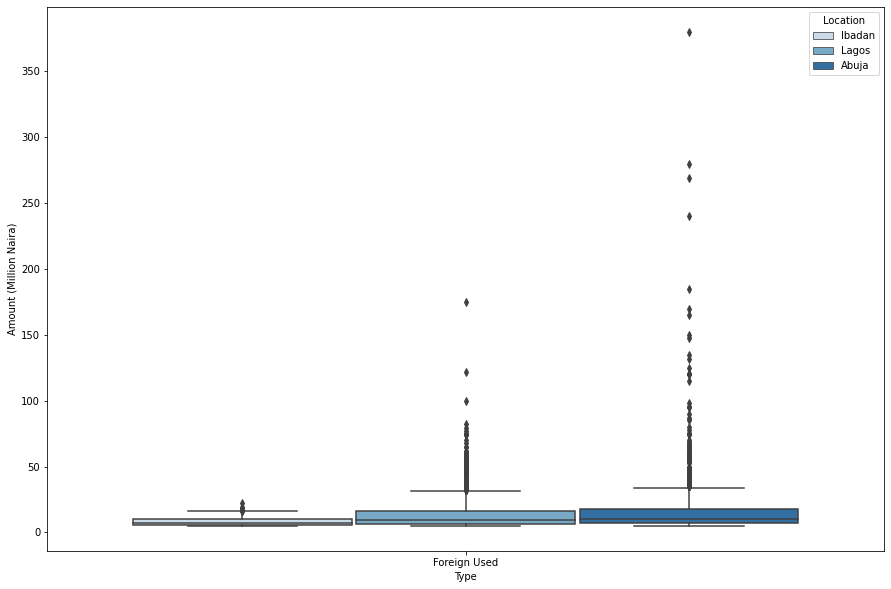

In [25]:

plt.figure(figsize=(15, 10))

sns.boxplot(x="Type", y="Amount (Million Naira)",
            data=data[(data["Amount (Million Naira)"] > nu_75)
                      & (data["Type"] == "Foreign Used")],
            hue="Location",
            hue_order=["Ibadan", "Lagos", "Abuja"],
            palette="Blues")

plt.savefig("./Image/fu_cars_with_prices_above_75th.jpg")

In [134]:
data[(data["Amount (Million Naira)"] > nu_75) & (data["Location"] == "Abuja")].describe()


,Year,Amount (Million Naira),Distance
count,1860.000000,1860.000000,1860.000000
mean,2014.883871,23.389317,62180.191935
std,3.734816,44.279232,43173.406573
min,2000.000000,4.850000,3.000000
25%,2012.000000,6.700000,38000.000000
50%,2015.000000,11.000000,70000.000000
75%,2018.000000,20.500000,74000.000000
max,2022.000000,456.000000,925343.000000


In [135]:
data[(data["Amount (Million Naira)"] > nu_75) & (data["Location"] == "Lagos")].describe()

,Year,Amount (Million Naira),Distance
count,2130.000000,2130.000000,2.130000e+03
mean,2012.835211,14.476000,8.117519e+04
std,3.802125,14.714013,9.569299e+04
min,2003.000000,4.830000,1.000000e+00
25%,2010.000000,6.500000,5.985125e+04
50%,2013.000000,9.500000,7.400000e+04
75%,2016.000000,16.500000,7.800000e+04
max,2021.000000,175.000000,1.284898e+06


In [136]:
data[(data["Amount (Million Naira)"] > nu_75) & (data["Location"] == "Ibadan")].describe()


,Year,Amount (Million Naira),Distance
count,172.000000,172.000000,172.000000
mean,2012.046512,8.274360,88927.613372
std,3.386962,3.579608,55131.141665
min,2004.000000,4.850000,3000.000000
25%,2010.000000,5.787500,68000.000000
50%,2012.000000,6.775000,74000.000000
75%,2015.000000,9.645000,99250.000000
max,2020.000000,22.000000,471102.000000


In [137]:
data[data["Type"] == "Brand New"].describe()


,Year,Amount (Million Naira),Distance
count,297.000000,226.000000,297.00000
mean,2019.673401,83.026460,8181.96633
std,3.258730,95.697261,34623.72284
min,1995.000000,1.150000,3.00000
25%,2020.000000,27.000000,700.00000
50%,2021.000000,48.500000,1000.00000
75%,2021.000000,95.000000,1024.00000
max,2022.000000,456.000000,337469.00000


In [138]:
data[data["Type"] == "Foreign Used"].describe()


,Year,Amount (Million Naira),Distance
count,6457.000000,5034.000000,6.457000e+03
mean,2011.563574,11.424913,8.472042e+04
std,4.465206,15.594693,8.675325e+04
min,1986.000000,0.910000,1.000000e+00
25%,2008.000000,4.500000,6.211100e+04
50%,2011.000000,6.800000,7.400000e+04
75%,2015.000000,13.000000,8.500000e+04
max,2022.000000,380.000000,1.284898e+06


In [139]:
data[data["Type"] == "Nigerian Used"].describe()


,Year,Amount (Million Naira),Distance
count,2512.000000,1945.000000,2.512000e+03
mean,2008.682723,4.618242,1.346987e+05
std,4.473121,6.242628,1.098811e+05
min,1979.000000,0.450000,1.000000e+00
25%,2006.000000,1.980000,9.512600e+04
50%,2008.000000,3.000000,1.124575e+05
75%,2012.000000,4.800000,1.375368e+05
max,2021.000000,135.000000,1.985400e+06


#### **Total Number of Cars per Type**

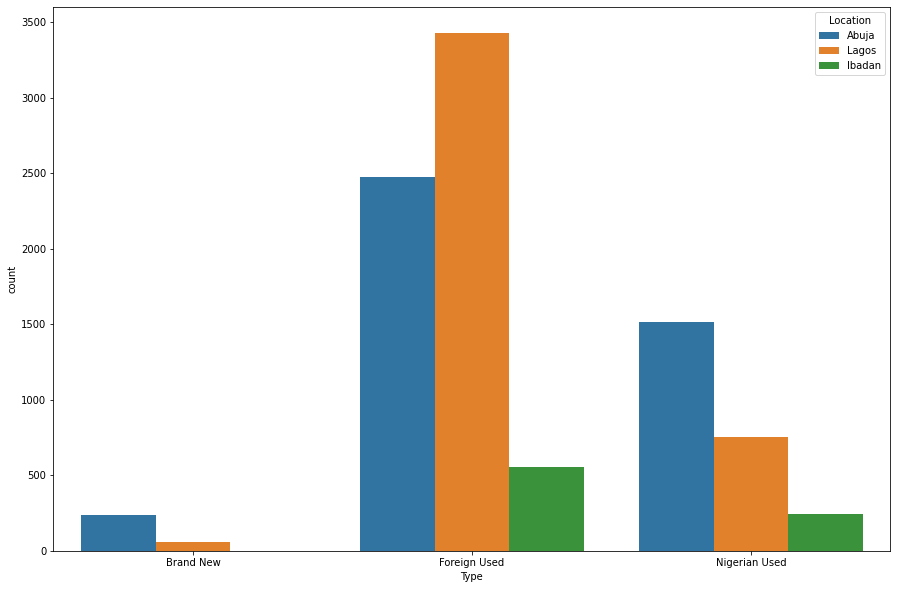

In [26]:
plt.figure(figsize=(15, 10))

sns.countplot(x="Type", data=data, hue="Location")

plt.savefig("./Image/total_number_of_cars_per_type.jpg")

#### **Car Distance by Location and Type**

<AxesSubplot:xlabel='Location', ylabel='Distance'>

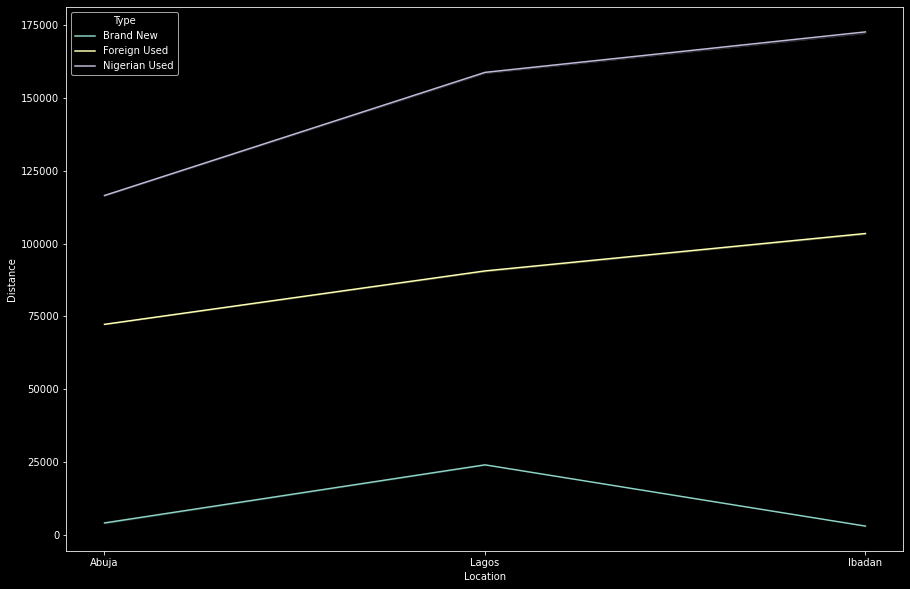

In [141]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    x="Location", y="Distance",
    data=data, hue="Type",
    ci=0
)


#### **Prices of Car by Maker Location and Type**

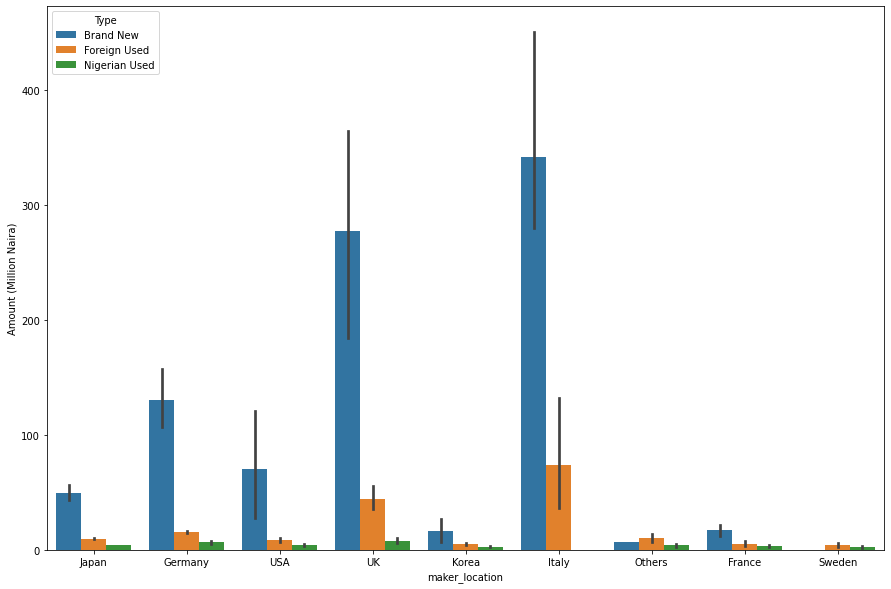

In [27]:
plt.figure(figsize=(15, 10))
sns.barplot(
    x="maker_location",
    y="Amount (Million Naira)",
    hue="Type",
    data=data
)

plt.savefig("./Image/prices_per_maker_loaction.jpg")

#### **Total Number of cars per maker location and type**

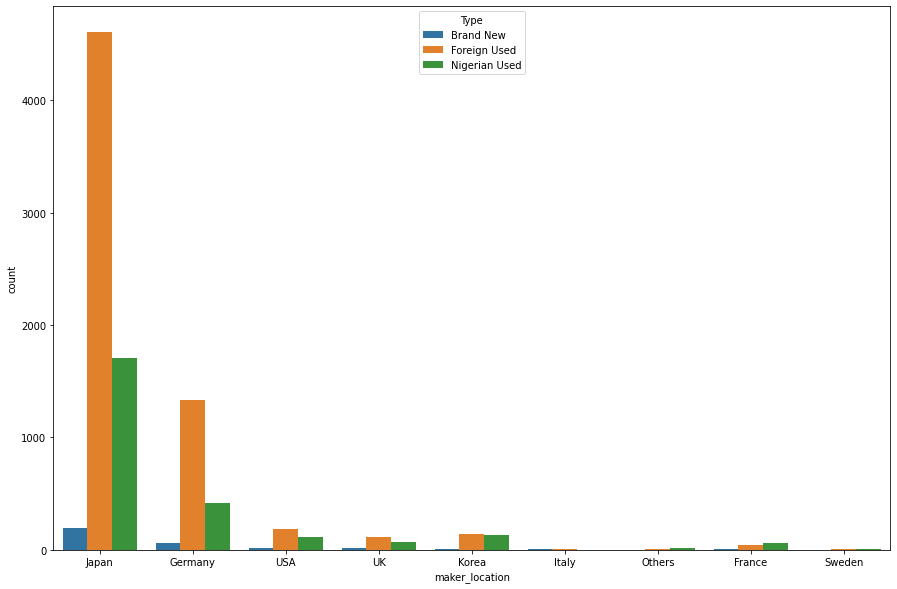

In [28]:
plt.figure(figsize=(15, 10))
sns.countplot(
    x="maker_location",
    hue="Type",
    data=data
)

plt.savefig("./Image/number_per_maker_loaction.jpg")

#### **Total Number of Cars per Maker**

In [144]:
data[data["maker_location"] == "Japan"]["Maker"].unique()

array(['Toyota', 'Lexus', 'Suzuki', 'Mitsubishi', 'Infiniti', 'Nissan',
       'Acura', 'Honda', 'Mazda', 'Scion', 'Subaru'], dtype=object)

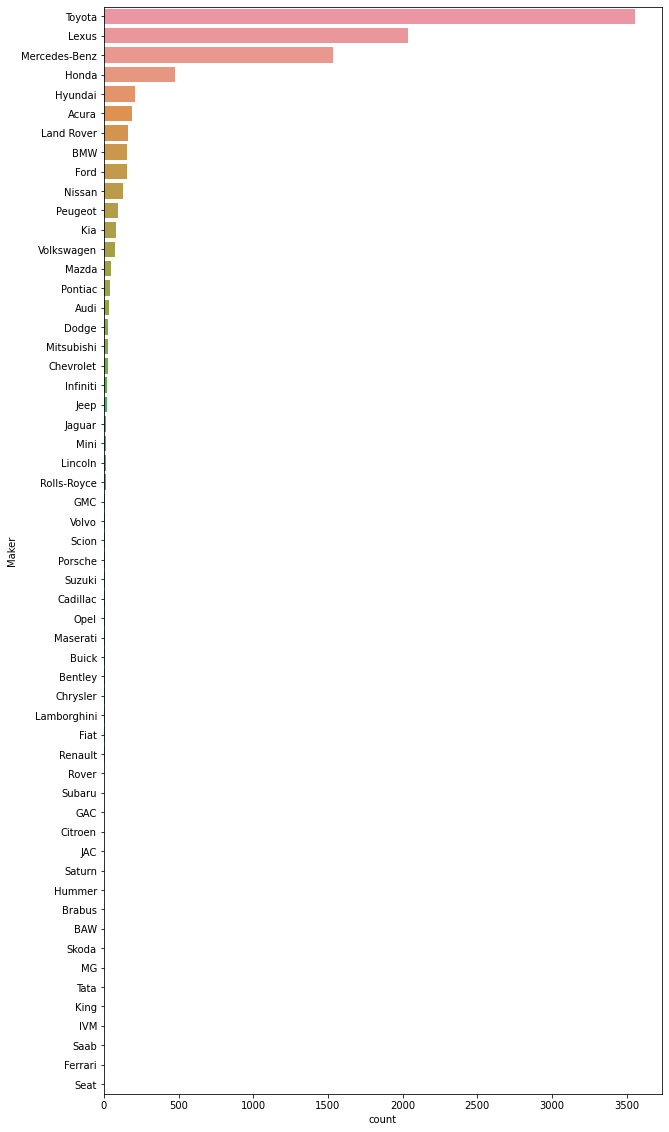

In [29]:
maker_dict = data["Maker"].value_counts().to_dict()
maker_list = []
for k in maker_dict:
    maker_list.append(k)

plt.figure(figsize=(10, 20))
sns.countplot(y="Maker", data=data, order=maker_list)
plt.savefig("./Image/number_per_maker.jpg")

## **Preprocessing and Model Selection**

### **Preprocessing**

In [146]:
cat_cols = ['Maker', 'Model', 'Type', "maker_location", "Model_name"]


In [147]:
def vectorizer(X, cols):
    
    df = X.copy()

    cv = CountVectorizer(
        analyzer="char",
        tokenizer=None,
        preprocessor=None,
        stop_words=None,
        max_features=5000,
    )

    for col in cols:

        section = [car for car in data[col]]

        cv.fit(section)
        arr_vector = cv.transform(section)
        arr_vector = arr_vector.toarray()
        vocab = cv.vocabulary_
        letter_data = pd.DataFrame(arr_vector, columns=vocab)

        df = pd.concat([df, letter_data], axis=1)

    return df


#### **Vectorization of Important Categorical Features**

In [148]:
data = vectorizer(data, cat_cols)
data.drop(cat_cols, axis=1, inplace=True)

data.drop(["Location", "Model_year", "Colour",
          "VehicleID"], axis=1, inplace=True)
data


,Year,Amount (Million Naira),Distance,data,t,o,y,a,l,e,...,6,2,j,k,z,9,q,7,8,1
0,2020,23.0,7523.0,train,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,2021,23.0,100.0,train,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,2018,52.0,1000.0,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2021,195.0,1000.0,train,0,1,0,1,1,1,...,0,0,2,0,0,0,0,0,0,0
4,2020,27.0,854.0,train,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9261,2009,NaN,138609.0,test,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
9262,2002,NaN,120000.0,test,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9263,2002,NaN,255895.0,test,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9264,2007,NaN,107882.0,test,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0


#### **Feature Selection**

In [149]:
train = data[data["data"] == "train"]
test = data[data["data"] == "test"]


In [150]:
for set in (train, test):
    set.drop("data", axis=1, inplace=True)


c:\Users\David-Daniel\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [152]:
test.drop("Amount (Million Naira)", inplace=True, axis=1)

c:\Users\David-Daniel\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### **Train Test Splitting**

In [153]:
X = train.drop("Amount (Million Naira)", axis=1)
y = train["Amount (Million Naira)"]


In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


#### **Scaling**

In [155]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### **Model Selection**

#### **SVR**

In [156]:
svr = SVR()

params = {
    'kernel': ["poly", 'rbf'],
    'degree': [2, 3],
    'C': [0.1, 0.5, 1.0, 5, 10, 20]
}
grid_svr = HalvingGridSearchCV(
    svr, param_grid=params, scoring="neg_mean_squared_error", cv=3, verbose=1)


In [157]:
grid_svr.fit(X_train_scaled, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 640
max_resources_: 5764
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 640
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 8
n_resources: 1920
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 3
n_resources: 5760
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, estimator=SVR(),
                    param_grid={'C': [0.1, 0.5, 1.0, 5, 10, 20],
                                'degree': [2, 3], 'kernel': ['poly', 'rbf']},
                    scoring='neg_mean_squared_error', verbose=1)

In [158]:
grid_svr.best_score_


-175.384303463927

In [159]:
svr = grid_svr.best_estimator_


#### **Random Forest Regressor**

In [160]:
rnd_forest = RandomForestRegressor(random_state=42, oob_score=True)

params = {
    'n_estimators': [100, 300, 500, 1000, 5000],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8]
}
grid_rnd_forest = HalvingGridSearchCV(
    rnd_forest, param_grid=params, scoring="neg_mean_squared_error", cv=3, verbose=1)


In [161]:
grid_rnd_forest.fit(X_train_scaled, y_train)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 213
max_resources_: 5764
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 213
Fitting 3 folds for each of 80 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 27
n_resources: 639
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 2
n_candidates: 9
n_resources: 1917
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 3
n_candidates: 3
n_resources: 5751
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3,
                    estimator=RandomForestRegressor(oob_score=True,
                                                    random_state=42),
                    param_grid={'max_depth': [2, 4, 6, 8],
                                'min_samples_split': [2, 4, 6, 8],
                                'n_estimators': [100, 300, 500, 1000, 5000]},
                    scoring='neg_mean_squared_error', verbose=1)

In [162]:
grid_rnd_forest.best_score_


-156.63858096116817

In [163]:
rnd_forest = grid_rnd_forest.best_estimator_


#### **Decision Tree Regressor**

In [164]:
dec_tree = DecisionTreeRegressor(random_state=42)

params = {
    "criterion": ["squared_error", "friedman_mse"],
    "min_samples_split": [x for x in range(1, 101) if x % 2 == 0],
    # 'n_estimators': [100, 300, 500, 1000],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}
grid_dec_tree = HalvingGridSearchCV(
    dec_tree, param_grid=params, scoring="neg_mean_squared_error", cv=3, verbose=1)


In [165]:
grid_dec_tree.fit(X_train_scaled, y_train)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 7
max_resources_: 5764
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 7
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
----------
iter: 1
n_candidates: 334
n_resources: 21
Fitting 3 folds for each of 334 candidates, totalling 1002 fits
----------
iter: 2
n_candidates: 112
n_resources: 63
Fitting 3 folds for each of 112 candidates, totalling 336 fits
----------
iter: 3
n_candidates: 38
n_resources: 189
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 4
n_candidates: 13
n_resources: 567
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 5
n_candidates: 5
n_resources: 1701
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 2
n_resources: 5103
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
                    param_grid={'criterion': ['squared_error', 'friedman_mse'],
                                'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18,
                                              20],
                                'min_samples_split': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28, 30, 32, 34, 36, 38,
                                                      40, 42, 44, 46, 48, 50,
                                                      52, 54, 56, 58, 60, ...]},
                    scoring='neg_mean_squared_error', verbose=1)

In [166]:
grid_dec_tree.best_score_


-234.18141819736738

In [167]:
dec_tree = grid_dec_tree.best_estimator_
dec_tree


DecisionTreeRegressor(max_depth=18, min_samples_split=42, random_state=42)

#### **XGBoost Algorithms**

In [168]:
xgr = xgb.XGBRFRegressor(random_state=402)

params = {
    "n_estimators": [100, 200, 500, 1000, 5000],
    'booster': ["gbtree", "gblinear"],
    "grow_policy": ['depthwise', 'lossguide'],
}

xgr_grid = HalvingGridSearchCV(
    xgr, param_grid=params, scoring="neg_mean_squared_error", cv=3, verbose=1)
xgr_grid.fit(X_train_scaled, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 640
max_resources_: 5764
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 640
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[23:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bynode", "grow_policy", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bynode", "grow_policy", "num_parallel_tree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting

HalvingGridSearchCV(cv=3,
                    estimator=XGBRFRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None, gamma=None,
                                             gpu_id=None, grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             max_bin=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=N...
                                             monotone_constraints=None

In [169]:
xgr_grid.best_score_


-176.42769591268896

In [170]:
xgr = xgr_grid.best_estimator_


#### **Voting Regressor**

In [171]:
voting = VotingRegressor([
    ('svr', svr),
    ('rnd_forest', rnd_forest),
    ('dec_tree', dec_tree),
    ('xgr', xgr),
])
voting.fit(X_train_scaled, y_train)


VotingRegressor(estimators=[('svr', SVR(C=20, kernel='poly')),
                            ('rnd_forest',
                             RandomForestRegressor(max_depth=8,
                                                   n_estimators=300,
                                                   oob_score=True,
                                                   random_state=42)),
                            ('dec_tree',
                             DecisionTreeRegressor(max_depth=18,
                                                   min_samples_split=42,
                                                   random_state=42)),
                            ('xgr',
                             XGBRFRegressor(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bytree=...
                                            importance_type=None,
                                            inter

## **Predictions**

In [172]:
y_pred = voting.predict(X_test_scaled)


In [173]:
mse = mse(y_test, y_pred)
np.sqrt(mse)


11.775540476433052